In [81]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import Template

Template = Template.Template()

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras_core as keras

# Set the random seed
keras.utils.set_random_seed(1234)

dtype='float64'
keras.backend.set_floatx(dtype)

PI = np.pi
PI_SQ = PI**2
DENOM = 1 + PI**4 

In [82]:
def make_model(neurons, n_layers, activation='tanh'):
    # CHANGED: Input shape is now (2,) to accept [x, t]
    xvals = keras.layers.Input(shape=(2,), name='xt_input', dtype=dtype)

    l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(xvals)
    for l in range(n_layers-2):
        l1 = keras.layers.Dense(neurons, activation=activation, dtype=dtype)(l1)
    output = keras.layers.Dense(1, activation=None, dtype=dtype)(l1)

    u_model = keras.Model(inputs=xvals, outputs=output, name='u_model')
    return u_model

In [83]:
class loss(keras.layers.Layer):
    def __init__(self, u_model, n_pts, f, **kwargs):
        super(loss, self).__init__()
        self.u_model = u_model
        self.n_pts = n_pts
        self.f = f

    def call(self, inputs):
        # 1. Collocation Points (PDE Loss)
        x = tf.random.uniform([self.n_pts, 1], minval=0., maxval=1., dtype=dtype)
        t = tf.random.uniform([self.n_pts, 1], minval=0., maxval=1., dtype=dtype)
        xt = tf.concat([x, t], axis=1)

        with tf.GradientTape(persistent=True) as t2:
            t2.watch(xt)
            with tf.GradientTape(persistent=True) as t1:
                t1.watch(xt)
                u = self.u_model(xt, training=True)
            
            grads = t1.gradient(u, xt)
            u_x = grads[:, 0:1]
            u_t = grads[:, 1:2]
        
        u_xx = t2.gradient(u_x, xt)[:, 0:1]
        
        # PDE: u_t + u_xx - f = 0
        error_PDE = keras.ops.mean((u_t + u_xx - self.f(xt))**2)

        # 2. Boundary Conditions (x=0, x=pi) -> u=0
        t_bc = tf.random.uniform([self.n_pts, 1], minval=0., maxval=1., dtype=dtype)
        bc_0 = tf.concat([tf.zeros_like(t_bc), t_bc], axis=1)
        bc_pi = tf.concat([tf.ones_like(t_bc), t_bc], axis=1)
        
        error_BC = keras.ops.mean(self.u_model(bc_pi)**2)+ keras.ops.mean(self.u_model(bc_0)**2) 

        # 3. Initial Condition (t=0)
        # The IC must match the exact solution at t=0
        # u(x,0) = -1/(1+pi^4) * cos(0) * sin(pi*x)
        x_ic = tf.random.uniform([self.n_pts, 1], minval=0., maxval=PI, dtype=dtype)
        ic_points = tf.concat([x_ic, tf.zeros_like(x_ic)], axis=1)
        
        # Calculate the exact value at t=0 for training targets
        u_ic_pred = self.u_model(ic_points)
        u_ic_true = (-1.0 / DENOM)* keras.ops.sin(PI * x_ic) # cos(0)=1
        
        error_IC = keras.ops.mean((u_ic_pred - u_ic_true)**2)

        return error_PDE + error_BC + error_IC

In [84]:
def make_loss_model(u_model, n_pts, f):
    xvals = keras.layers.Input(shape=(2,), name='xt_input', dtype=dtype)
    output = loss(u_model, n_pts, f)(xvals)
    loss_model = keras.Model(inputs=xvals, outputs=output)
    return loss_model


def tricky_loss(y_pred, y_true):
    return y_true

In [85]:


def f_rhs(xt):
    x = xt[:, 0:1]
    t = xt[:, 1:2]
    # f = sin(pi*x) * sin(t)
    return keras.ops.sin(PI * x) * keras.ops.sin(t)

nn = 20
nl = 5
n_pts = 1000
iterations = 3000

u_model = make_model(neurons=nn, n_layers=nl)
loss_model = make_loss_model(u_model, n_pts, f_rhs)

optimizer = keras.optimizers.Adam(learning_rate=10**-3)
loss_model.compile(optimizer=optimizer, loss=tricky_loss)

# Dummy input must match new shape (1, 2)
history = loss_model.fit(np.array([[1., 1.]]), np.array([1.]), epochs=iterations)

Epoch 1/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.3194
Epoch 2/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2554
Epoch 3/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2117
Epoch 4/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1722
Epoch 5/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1391
Epoch 6/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1349
Epoch 7/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1190
Epoch 8/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1289
Epoch 9/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1276
Epoch 10/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1153
Epoch 11/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.1105
Epoch 12/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.1054
Epoch 13/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1111
Epoch 14/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0916
Epoch 15/3000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0918
Epoch

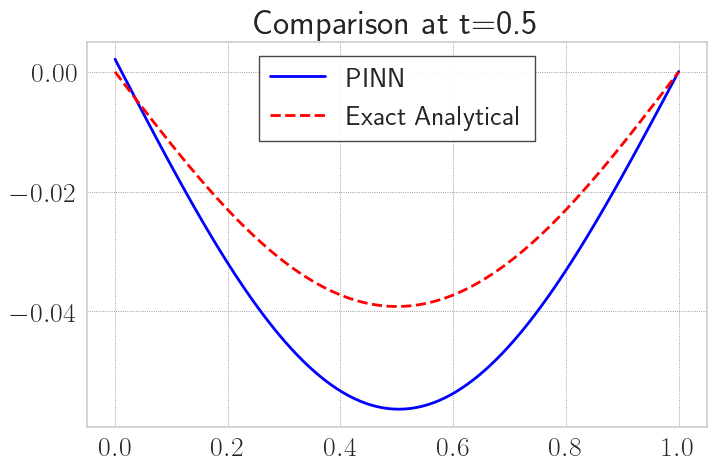

In [92]:
def exact_u(x, t):
    # Analytical solution derived for u_t + u_xx = f
    # u = 1/(1+pi^4) * (pi^2*sin(t) - cos(t)) * sin(pi*x)
    term_time = PI_SQ * np.sin(t) - np.cos(t)
    term_space = np.sin(PI * x)
    return (-1.0 / DENOM) * term_time * term_space



# Check fit at t=0.5
x_vals = np.linspace(0, 1., 100)
t_val = 0.5
xt_test = np.column_stack((x_vals, np.full_like(x_vals, t_val)))

u_pred_plot = u_model.predict(xt_test, verbose=0)
u_exact_plot = exact_u(x_vals, t_val)

plt.figure(figsize=(8,5))
plt.plot(x_vals, u_pred_plot, 'b-', label='PINN')
plt.plot(x_vals, u_exact_plot, 'r--', label='Exact Analytical')
plt.title(f'Comparison at t={t_val}')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()



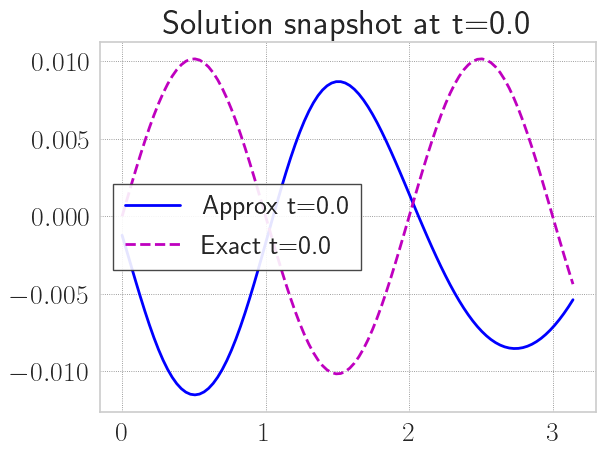

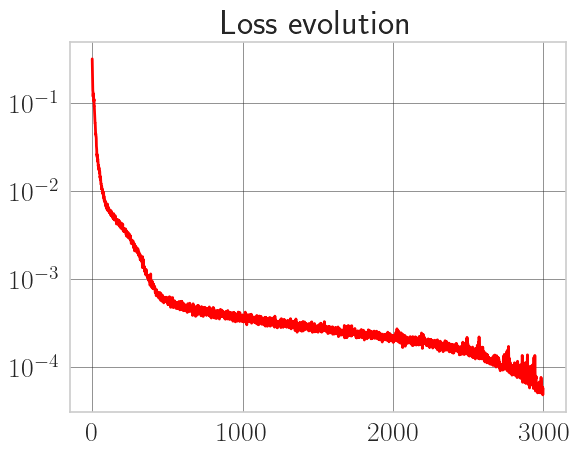

In [93]:
# Create grid for t=0.0
x_vals = np.linspace(0, np.pi, 100)
t_val = 0.0
xt_test = np.column_stack((x_vals, np.full_like(x_vals, t_val)))

fig, ax = plt.subplots()
plt.plot(x_vals, u_model(xt_test), 'b-', label='Approx t=0.0')
plt.plot(x_vals, exact_u(x_vals, t_val), 'm--', label='Exact t=0.0')
plt.legend()
plt.grid(True, linestyle=':')
plt.title(f"Solution snapshot at t={t_val}")
plt.show()

# Plot Loss
plt.figure()
plt.plot(history.history['loss'], color='r')
plt.yscale('log')
plt.title("Loss evolution")
plt.show()

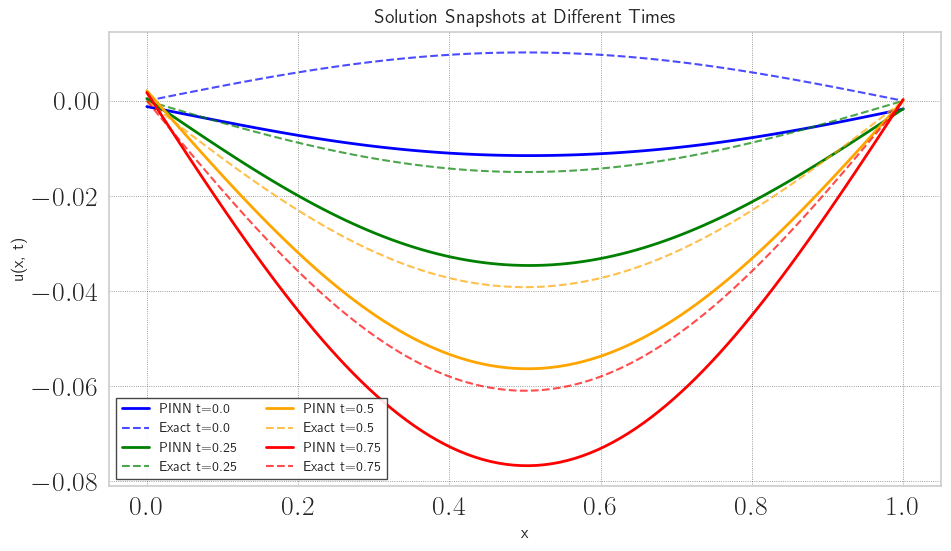

In [94]:
# Plot solution snapshots at multiple time points
fig, ax = plt.subplots(figsize=(10, 6))

# Define time snapshots
time_snapshots = [0.0, 0.25, 0.5, 0.75]
colors = ['blue', 'green', 'orange', 'red']
x_vals = np.linspace(0, 1, 100)

for t_val, color in zip(time_snapshots, colors):
    # Create input data for the model
    xt_test = np.column_stack((x_vals, np.full_like(x_vals, t_val)))
    
    # Get predictions
    u_pred = u_model.predict(xt_test, verbose=0).flatten()
    
    # Get exact solution
    u_exact = exact_u(x_vals, t_val)
    
    # Plot both
    ax.plot(x_vals, u_pred, '-', color=color, linewidth=2, 
            label=f'PINN t={t_val}')
    ax.plot(x_vals, u_exact, '--', color=color, linewidth=1.5, 
            alpha=0.7, label=f'Exact t={t_val}')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('u(x, t)', fontsize=12)
ax.set_title('Solution Snapshots at Different Times', fontsize=14)
ax.legend(loc='best', fontsize=10, ncol=2)
ax.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

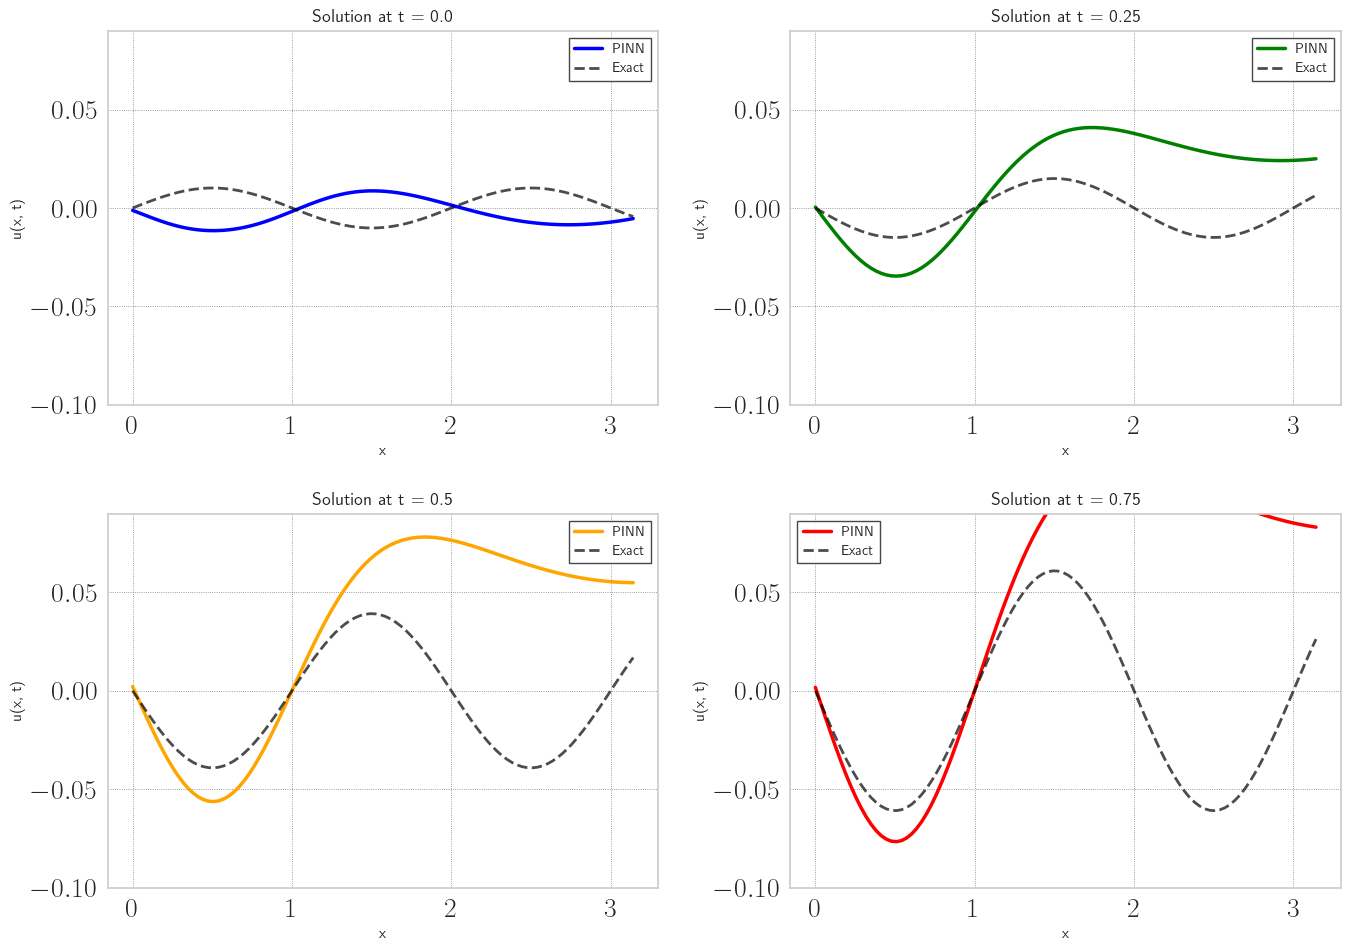

In [95]:
# Plot solution snapshots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define time snapshots
time_snapshots = [0.0, 0.25, 0.5, 0.75]
colors = ['blue', 'green', 'orange', 'red']
x_vals = np.linspace(0, np.pi, 100)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

for idx, (t_val, color, ax) in enumerate(zip(time_snapshots, colors, axes_flat)):
    # Create input data for the model
    xt_test = np.column_stack((x_vals, np.full_like(x_vals, t_val)))
    
    # Get predictions
    u_pred = u_model.predict(xt_test, verbose=0).flatten()
    
    # Get exact solution
    u_exact = exact_u(x_vals, t_val)
    
    # Plot both on the corresponding subplot
    ax.plot(x_vals, u_pred, '-', color=color, linewidth=2.5, label='PINN')
    ax.plot(x_vals, u_exact, '--', color='black', linewidth=2, 
            alpha=0.7, label='Exact')
    
    # Set consistent axis ranges for all subplots
    ax.set_ylim(-0.1, 0.09)
    
    # Format each subplot
    ax.set_xlabel('x', fontsize=11)
    ax.set_ylabel('u(x, t)', fontsize=11)
    ax.set_title(f'Solution at t = {t_val}', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

<>:41: SyntaxWarning: invalid escape sequence '\p'
<>:41: SyntaxWarning: invalid escape sequence '\p'
C:\Users\ricar\AppData\Local\Temp\ipykernel_1448\3103075292.py:41: SyntaxWarning: invalid escape sequence '\p'
  ax1.set_title('PINN Solution Surface $\partial_t u + \Delta u = f$', fontsize=18, pad=10)


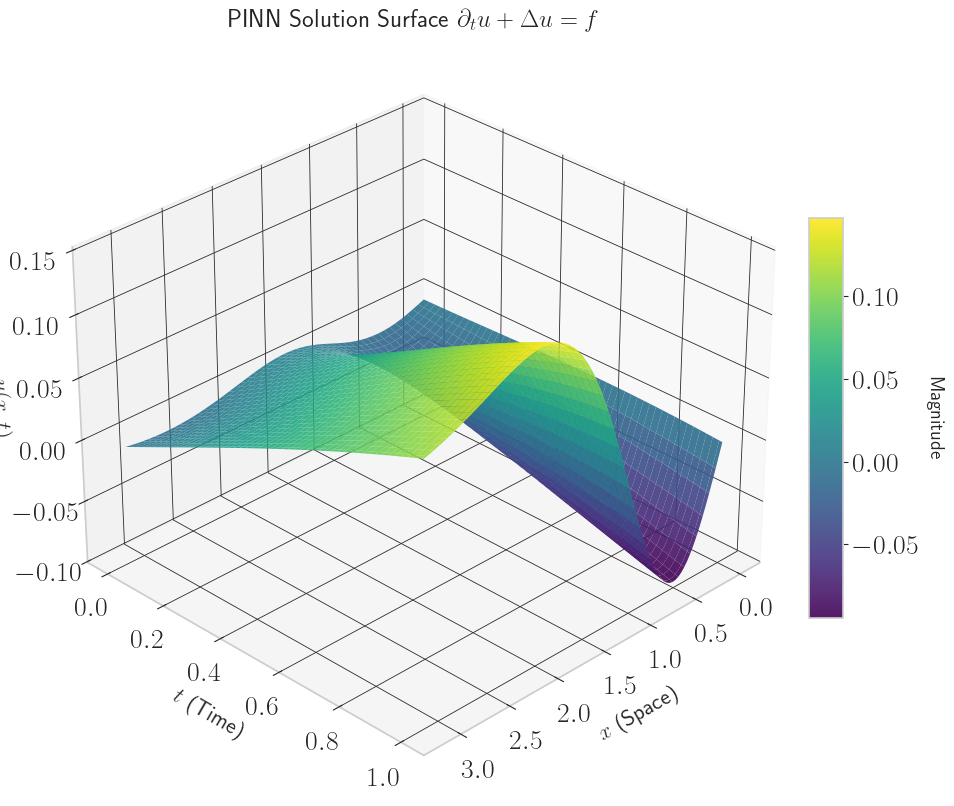

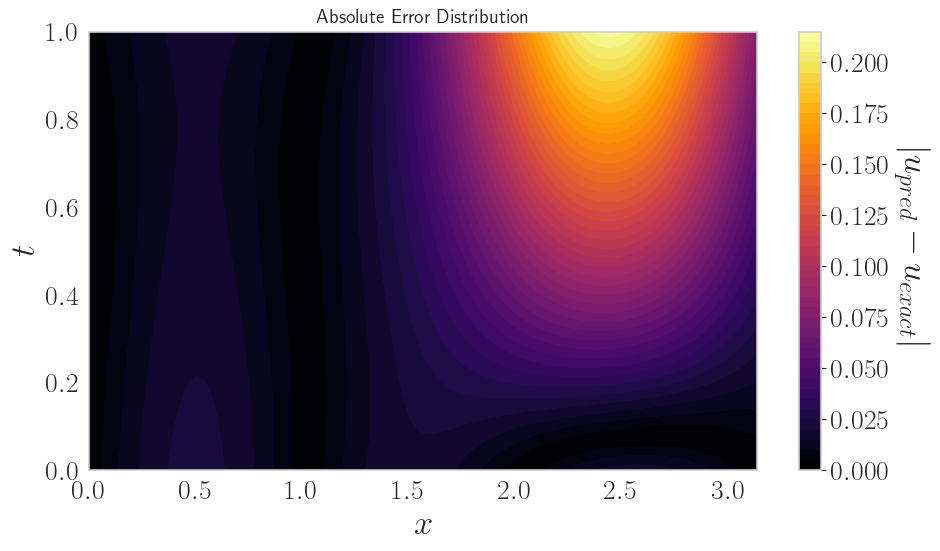

In [96]:
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

# =============================================================================
#           PREPARE DATA FOR PLOTTING
# =============================================================================
# 1. Generate a meshgrid for (x, t)
N_plot = 100
x_space = np.linspace(0, np.pi, N_plot)
t_space = np.linspace(0, 1, N_plot)
X, T = np.meshgrid(x_space, t_space)

# 2. Flatten and combine to feed into the NN (N_plot^2, 2)
X_flat = X.flatten()[:, None]
T_flat = T.flatten()[:, None]
input_data = np.hstack((X_flat, T_flat))

# 3. Predict and Reshape
U_pred = u_model.predict(input_data, verbose=0).reshape(N_plot, N_plot)

# 4. Exact Solution using the correct exact_u function
U_exact = exact_u(X, T)

# =============================================================================
#           PLOT 1: 3D SURFACE PLOT (SPACETIME)
# =============================================================================
fig1 = plt.figure(figsize=(14, 10))

# Create axes with manual positioning [left, bottom, width, height]
# Shift the plot to the right to make room for z-axis label
ax1 = fig1.add_axes([0.15, 0.1, 0.65, 0.8], projection='3d')

# Plot surface with a "coolwarm" map to distinguish peaks/valleys
surf = ax1.plot_surface(X, T, U_pred, cmap='viridis', 
                       edgecolor='none', alpha=0.9, antialiased=True)

# Formatting with increased labelpad for z-axis
ax1.set_xlabel('$x$ (Space)', fontsize=16, labelpad=12)
ax1.set_ylabel('$t$ (Time)', fontsize=16, labelpad=12)
ax1.set_zlabel('$u(x,t)$', fontsize=16, labelpad=12)
ax1.set_title('PINN Solution Surface $\partial_t u + \Delta u = f$', fontsize=18, pad=10)
ax1.view_init(elev=30, azim=45)

# Increase padding for tick labels
ax1.tick_params(axis='x', pad=5)
ax1.tick_params(axis='y', pad=5)
ax1.tick_params(axis='z', pad=8)

# Add a color bar with better positioning
cbar = fig1.colorbar(surf, ax=ax1, shrink=0.5, aspect=12, pad=0.02)
cbar.set_label('Magnitude', rotation=270, labelpad=18, fontsize=14)

plt.savefig('pinn_surface_plot.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
#           PLOT 2: ABSOLUTE ERROR HEATMAP
# =============================================================================
fig2, ax2 = plt.subplots(figsize=(10, 6))

# Calculate absolute error
abs_error = np.abs(U_pred - U_exact)

# Create a contour plot
cf = ax2.contourf(X, T, abs_error, levels=50, cmap='inferno')

cbar2 = fig2.colorbar(cf, ax=ax2)
cbar2.set_label('$|u_{pred} - u_{exact}|$', rotation=270, labelpad=30)

ax2.set_xlabel('$x$')
ax2.set_ylabel('$t$')
ax2.set_title('Absolute Error Distribution', fontsize=14)

plt.tight_layout()
plt.show()

Saving animation as GIF...
✓ Animation saved as 'pinn_diffusion.gif'
Saving animation as MP4...
Could not save MP4 (ffmpeg may not be installed): [WinError 2] The system cannot find the file specified

Displaying animation in notebook...


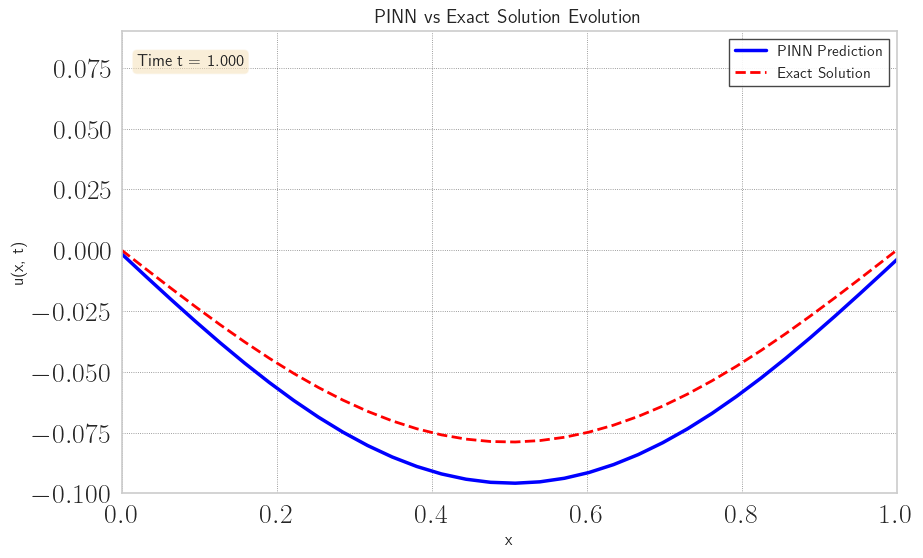

In [97]:
from matplotlib.animation import PillowWriter, FFMpegWriter
from IPython.display import HTML

# Recalculate U_exact using the correct exact_u function
U_exact_corrected = exact_u(X, T)

# Create a working animation and export it

# Prepare the figure
fig_anim, ax_anim = plt.subplots(figsize=(10, 6))
ax_anim.set_xlim(0, 1.)
ax_anim.set_ylim(-0.1, 0.09)
ax_anim.set_xlabel('x', fontsize=12)
ax_anim.set_ylabel('u(x, t)', fontsize=12)
ax_anim.set_title('PINN vs Exact Solution Evolution', fontsize=14)
ax_anim.grid(True, linestyle=':', alpha=0.6)

# Initialize plot elements
line_pred_anim, = ax_anim.plot([], [], 'b-', lw=2.5, label='PINN Prediction')
line_exact_anim, = ax_anim.plot([], [], 'r--', lw=2, label='Exact Solution')
time_text_anim = ax_anim.text(0.02, 0.95, '', transform=ax_anim.transAxes, 
                              fontsize=12, verticalalignment='top',
                              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax_anim.legend(loc='upper right', fontsize=11)

def init_anim():
    line_pred_anim.set_data([], [])
    line_exact_anim.set_data([], [])
    time_text_anim.set_text('')
    return line_pred_anim, line_exact_anim, time_text_anim

def animate_frame(i):
    # Get solution at time step i
    u_pred_frame = U_pred[i, :]
    u_exact_frame = U_exact_corrected[i, :]
    
    line_pred_anim.set_data(x_space, u_pred_frame)
    line_exact_anim.set_data(x_space, u_exact_frame)
    
    current_time = t_space[i]
    time_text_anim.set_text(f'Time t = {current_time:.3f}')
    
    return line_pred_anim, line_exact_anim, time_text_anim

# Create animation
anim = animation.FuncAnimation(fig_anim, animate_frame, init_func=init_anim,
                              frames=N_plot, interval=50, blit=True, repeat=True)

# Save as GIF (this usually works well)
print("Saving animation as GIF...")
writer_gif = PillowWriter(fps=20)
anim.save('pinn_diffusion.gif', writer=writer_gif)
print("✓ Animation saved as 'pinn_diffusion.gif'")

# Try to save as MP4 (requires ffmpeg)
try:
    print("Saving animation as MP4...")
    writer_mp4 = FFMpegWriter(fps=20, bitrate=1800)
    anim.save('pinn_diffusion.mp4', writer=writer_mp4)
    print("✓ Animation saved as 'pinn_diffusion.mp4'")
except Exception as e:
    print(f"Could not save MP4 (ffmpeg may not be installed): {e}")

# Display the animation in the notebook using HTML
print("\nDisplaying animation in notebook...")
HTML(anim.to_jshtml())